In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from NEID_solar_functions import *
from GP_kernels import *


In [2]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp

jax.config.update("jax_enable_x64", True)

uHz_conv = 1e-6 * 60

def gaussian_2(x, amp, mu, sig):
    return amp * jnp.exp(-jnp.power(x - mu, 2.) / (2 * jnp.power(sig, 2.))) 

amp, mu, sig = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])    
amp *= 6e1
nu_max = mu
delta_nu = 135
epsilon = 0
Q = 4e2
N = 19 # 25*135/2=1620
    
kernel = 0  
for i in range(N):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

2022-11-11 16:32:31.579182: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-11 16:32:31.611167: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-11 16:32:31.612536: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/jul

0.04535735628818486
0.0687090637681386
0.09911987920425651
0.13617203661431207
0.17815398337889624
0.22196452877492187
0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595
0.22196452877492187
0.17815398337889624
0.13617203661431207
0.09911987920425651
0.0687090637681386
0.04535735628818486


### Scenario 1 - 700 min, 50 repetitions

In [3]:
Nr = 500
t = np.linspace(0, 700, 701)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
t.shape, y.shape

((701,), (500, 701))

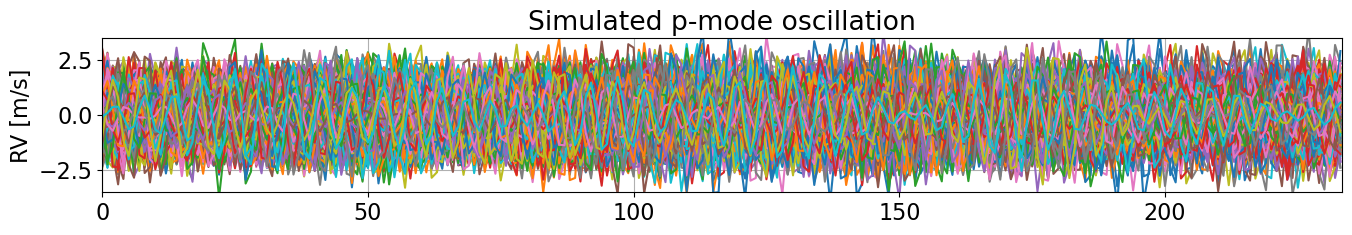

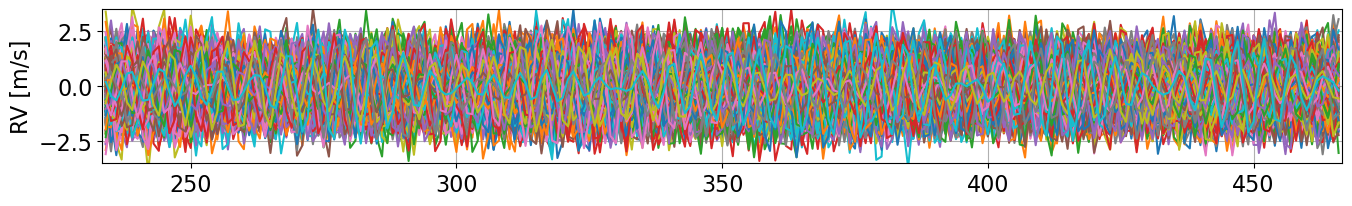

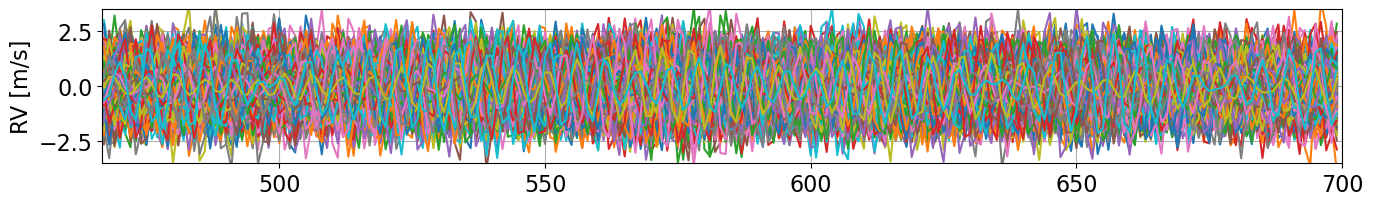

In [4]:
plt.rcParams.update({'font.size': 16})
T_env = max(t)/3

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    if i==0:
        plt.title('Simulated p-mode oscillation')
    idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
    plt.plot(t[idx_t], y.T[idx_t], '-', alpha=1)
    plt.ylabel('RV [m/s]')
    plt.xlim([i*T_env, (i+1)*T_env])
    plt.ylim([-3.5, 3.5])
    plt.grid(True)
    plt.show()

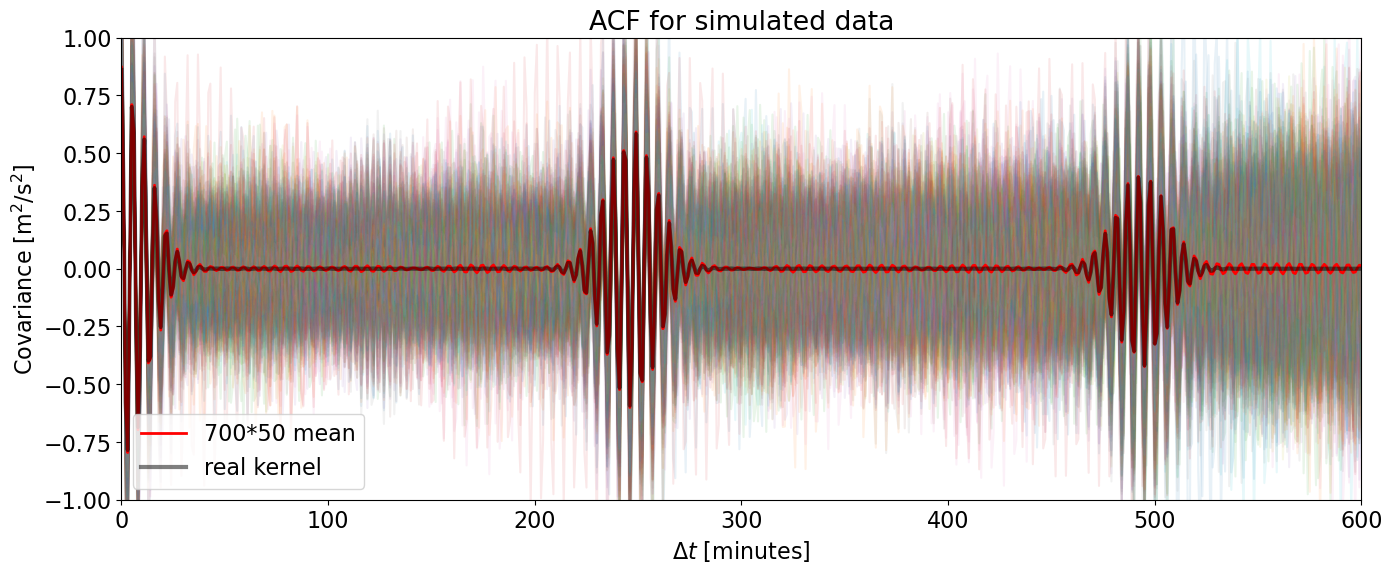

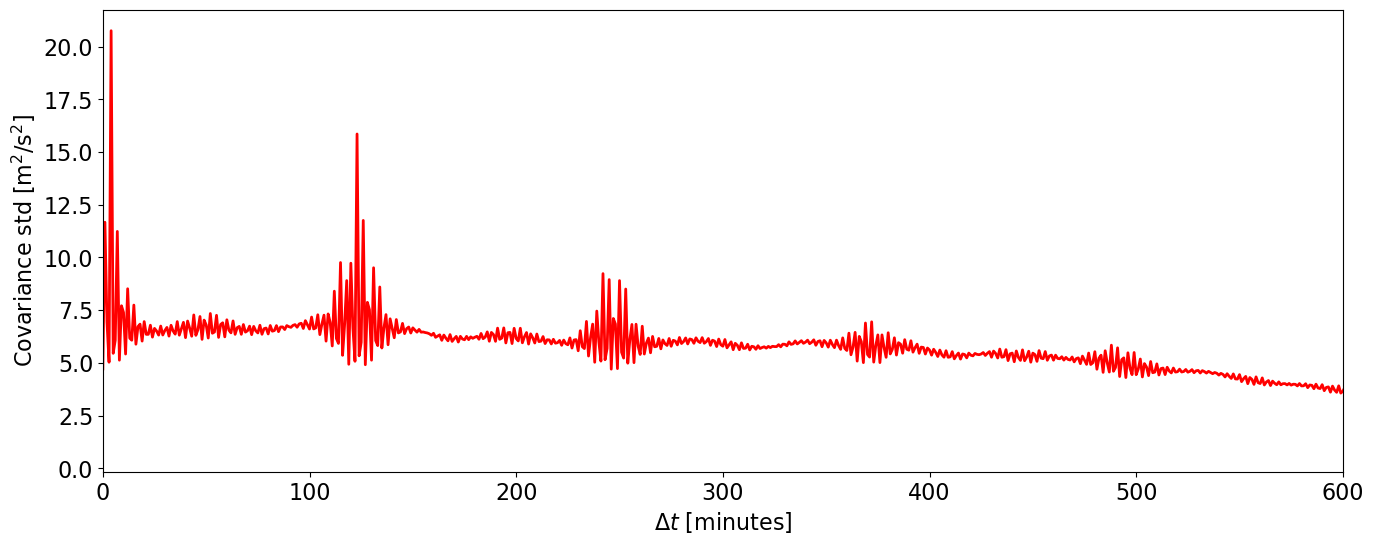

In [5]:
ACF = np.zeros((Nr, len(t)))

for i in range(Nr):
    ACF[i,:] = sm.tsa.acovf(y[i,:], fft=True)/(1-t/max(t*1.001))

fig = plt.figure(figsize=(16, 6))
plt.plot(t, ACF.T, alpha=0.1)
plt.plot(t, np.mean(ACF, axis=0), lw=2, color='r', label='700*50 mean')
plt.plot(t, kernel(t, t[:1]), lw=3, color='k', alpha=0.5, label='real kernel')
plt.title('ACF for simulated data')
plt.xlim([0,600])
plt.ylim([-1,1.0])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()

fig = plt.figure(figsize=(16, 6))
plt.plot(t, 1/np.std(ACF, axis=0), lw=2, color='r', label='700*50 std')
plt.xlim([0,600])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance std [m$^2$/s$^2$]')
plt.show()

In [8]:
ACF.shape

(500, 701)

In [9]:
ACF2 = ACF

### Scenario 2 - 35000 (50*700) min

In [10]:
Nr = 1
t = np.linspace(0, 35000, 35001)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
t.shape, y.shape

((35001,), (1, 35001))

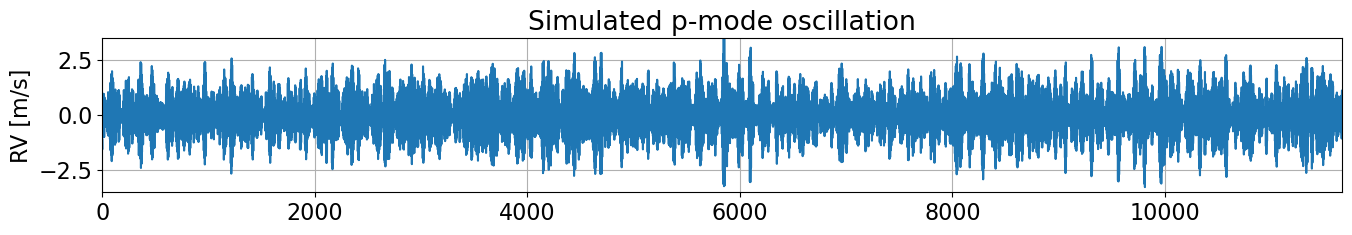

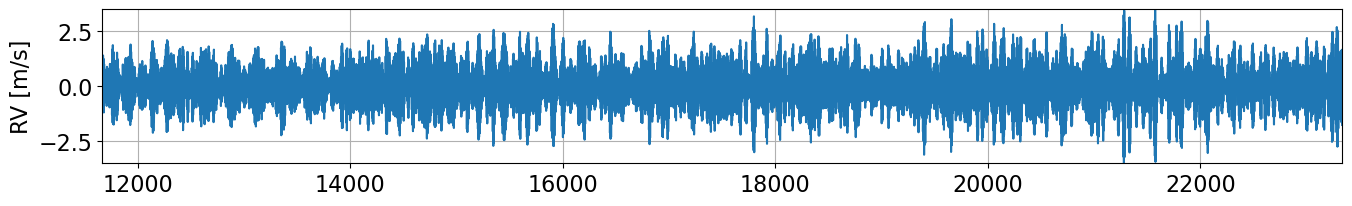

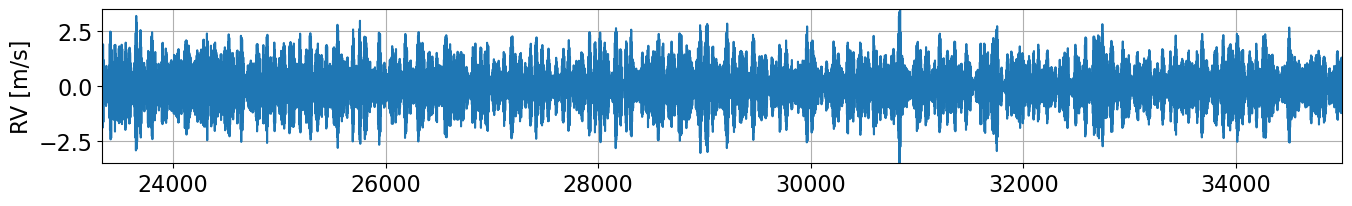

In [11]:
plt.rcParams.update({'font.size': 16})
T_env = max(t)/3

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    if i==0:
        plt.title('Simulated p-mode oscillation')
    idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
    plt.plot(t[idx_t], y.T[idx_t], '-', alpha=1)
    plt.ylabel('RV [m/s]')
    plt.xlim([i*T_env, (i+1)*T_env])
    plt.ylim([-3.5, 3.5])
    plt.grid(True)
    plt.show()

In [12]:
ACF.shape

(500, 701)

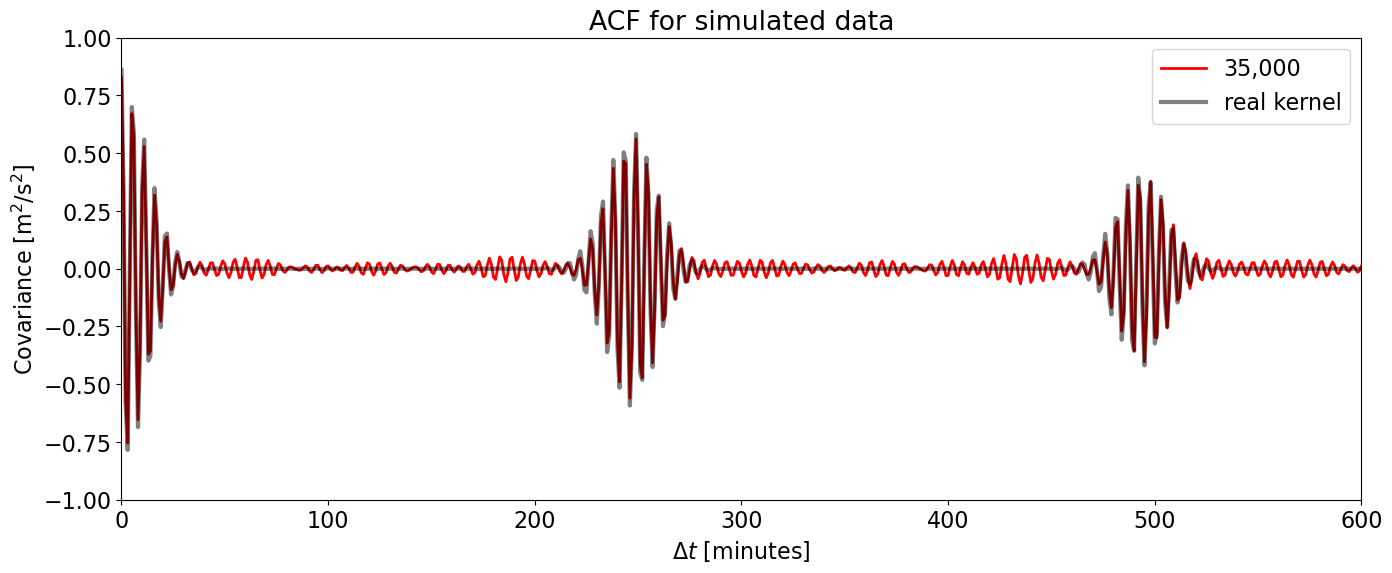

In [13]:
ACF = np.zeros((Nr, len(t)))

for i in range(Nr):
    ACF[i,:] = sm.tsa.acovf(y[i,:], fft=True)/(1-t/max(t*1.001))

fig = plt.figure(figsize=(16, 6))
# plt.plot(t[t<=700], np.mean(ACF2, axis=0), lw=2, color='b', label='50*700')
plt.plot(t, np.mean(ACF, axis=0), lw=2, color='r', label='35,000')
plt.plot(t, kernel(t, t[:1]), lw=3, color='k', alpha=0.5, label='real kernel')
# plt.plot(t, kernel(t[:1], t)[0], lw=3, color='k', alpha=0.5, label='real kernel 2')
plt.title('ACF for simulated data')
plt.xlim([0,600])
plt.ylim([-1,1.0])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()


# One day of data

## Test 1.1 - time domain

In [14]:
Nr = 1
t = np.linspace(0, 700, 701)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]
t.shape, y.shape

((701,), (701,))

In [15]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(1000),
    # "log_A": np.log(amp0),
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3080),
    # "log_delta_nu": np.log(135),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -695.0067163556943
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(459.51789819, dtype=float64)}


In [16]:
w_init = jnp.zeros(len(theta_init))
lower_bounds = jnp.ones_like(w_init)* (-1)
upper_bounds = jnp.ones_like(w_init) * jnp.inf
bounds = (lower_bounds, upper_bounds)

import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: -868.0836113853946


In [17]:
soln.params

{'log_Q': DeviceArray(6.02481634, dtype=float64)}

In [18]:
for key, value in soln.params.items():
    print(key[4:], np.exp(value))

Q 413.56567992028175


## Test 1.2 - Covariance space

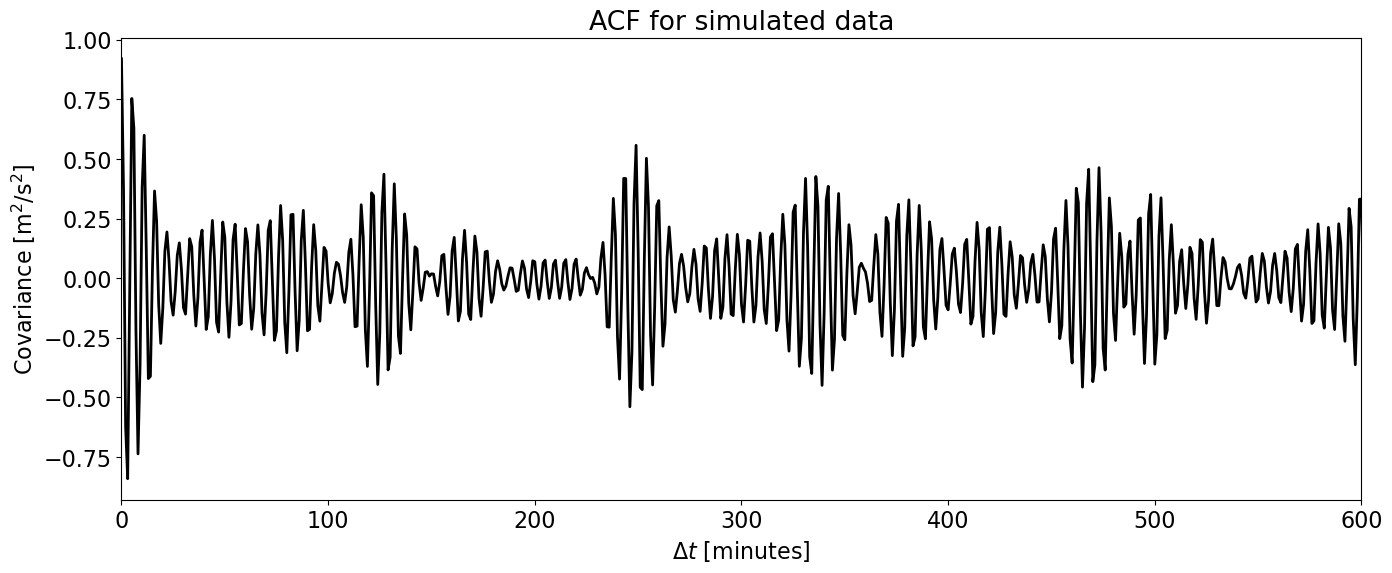

In [19]:
acf = sm.tsa.acovf(y, fft=True)/(1-t/max(t*1.001))
fig = plt.figure(figsize=(16, 6))
plt.plot(t, acf, lw=2, color='k')
plt.title('ACF for simulated data')
plt.xlim([0,600])
# plt.ylim([-1,1.0])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.show()


In [20]:
def kernel_function(Q):
    kernel = 0  
    for i in range(3):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    return kernel

dx = t[t<=600]
def diff(Q):
    kernel = kernel_function(Q)
    return (jnp.array(kernel(dx, dx[:1])).T-acf[t<=600]).flatten()

def objective_function(Q):
    return np.array([np.sum(diff(Q)**2)])[0]

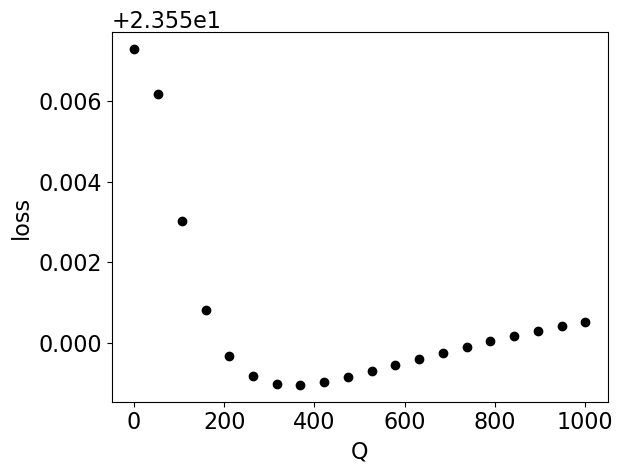

In [21]:
for xx in np.linspace(1, 1000, 20):
    plt.plot(xx, objective_function(xx), 'ko')
    plt.xlabel('Q')
    plt.ylabel('loss')
plt.show()

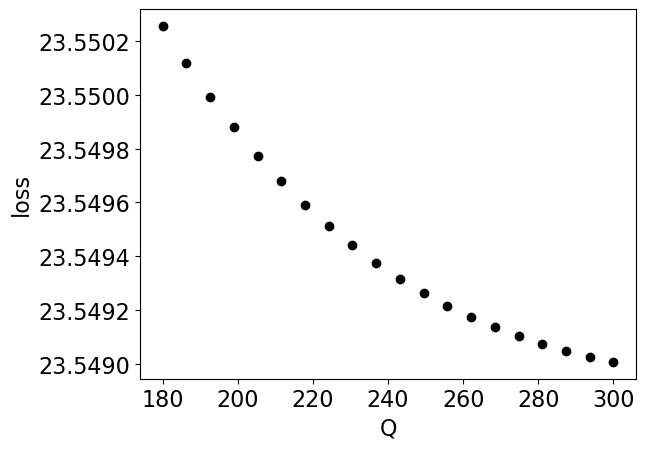

In [22]:
for xx in np.linspace(180, 300, 20):
    plt.plot(xx, objective_function(xx), 'ko')
    plt.xlabel('Q')
    plt.ylabel('loss')
plt.show()

In [23]:
# res = minimize(objective_function, x0=np.array([400]))

In [24]:
# def test_fun_1(x):
#     return x-1
# def test_fuc(x):
#     return np.array([test_fun_1(x)**2])
# res = minimize(test_fuc, x0=np.array([400]))
# res.x

In [25]:
np.array([np.sum(diff(Q)**2)])[0]

23.548988160941

In [26]:
objective_function(Q)

23.548988160941

In [27]:
type(objective_function(Q))

numpy.float64

In [28]:
np.asarray([sum(diff(Q)**2)]).shape

(1,)

In [29]:
jax.numpy.array(2.1)

DeviceArray(2.1, dtype=float64, weak_type=True)

# Multiple days of data combined 

In [30]:
Nr = 1
t = np.linspace(0, 35000, 35001)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
t.shape, y.shape

((35001,), (1, 35001))

## Test 2.1 - Covariance space

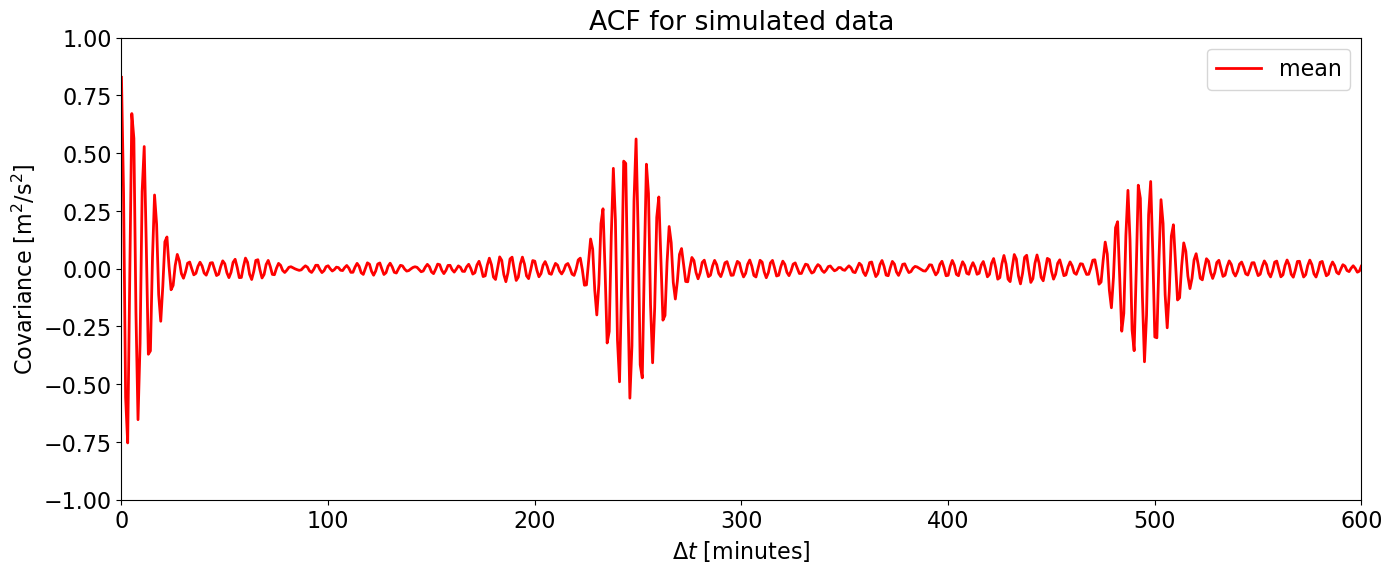

In [31]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, np.mean(ACF, axis=0), lw=2, color='r', label='mean')
plt.title('ACF for simulated data')
plt.xlim([0,600])
plt.ylim([-1,1.0])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()

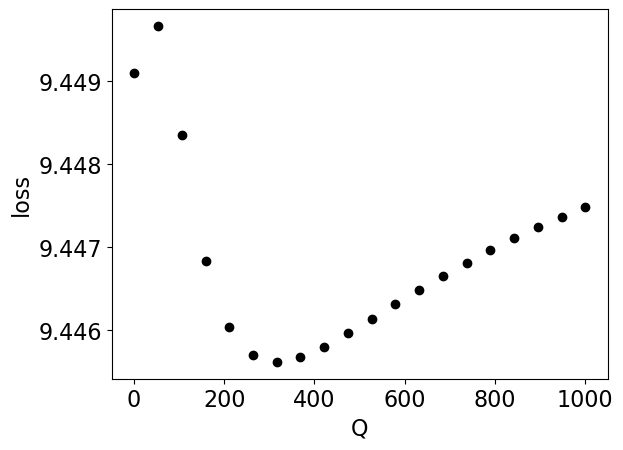

In [32]:
acf = ACF[0, :]

for xx in np.linspace(1, 1000, 20):
    plt.plot(xx, objective_function(xx), 'ko')
    plt.xlabel('Q')
    plt.ylabel('loss')
plt.show()

In [33]:
acf.shape, t.shape, y.shape

((35001,), (35001,), (1, 35001))

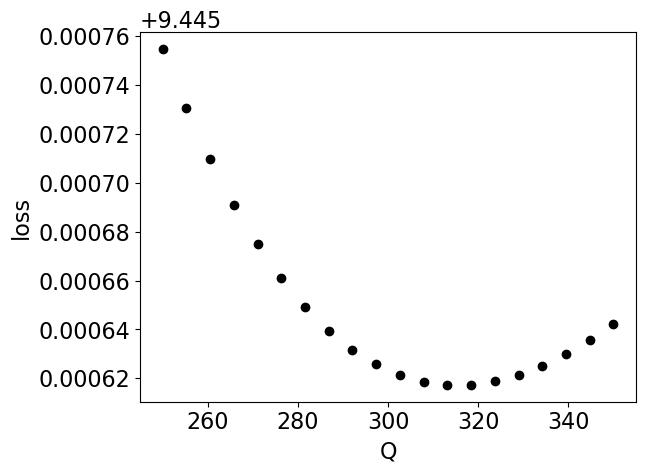

In [34]:
for xx in np.linspace(250, 350, 20):
    plt.plot(xx, objective_function(xx), 'ko')
    plt.xlabel('Q')
    plt.ylabel('loss')
plt.show()

In [35]:
# loss = np.sum((np.mean(ACF, axis=0)[t<=600] - np.array(kernel(dx, dx[:1])).flatten())**2)

# if 0:
#     from scipy.optimize import minimize
#     # bounds = [(0,1), (200, 500)]
#     res = minimize(
#         loss,
#         x0=([400]),
#         # args=(amp, Q,),
#         # bounds=bounds,
#     )

In [36]:
# y= y[0,:]

theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(1000),
    # "log_A": np.log(amp0),
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3080),
    # "log_delta_nu": np.log(135),
    # "epsilon": np.float64(0.0)
}

obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

w_init = jnp.zeros(len(theta_init))
lower_bounds = jnp.ones_like(w_init)* (-1)
upper_bounds = jnp.ones_like(w_init) * jnp.inf
bounds = (lower_bounds, upper_bounds)

import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, bounds=bounds, X=t, y= y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

ValueError: scan got values with different leading axis sizes: 35001, 35001, 35001, 35001, 1.

In [ ]:
soln.params

In [ ]:
for key, value in soln.params.items():
    print(key[4:], np.exp(value))

In [ ]:
X1 = np.arange(10)
X2 = 10-np.arange(10)

jnp.abs(X1 - X2)[..., None]

In [ ]:
jnp.abs(X1 - X2)